### Prerequisite Packages

In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [3]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
# Ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Worker seed function for DataLoader
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)

        return seed_worker

In [5]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Modality Assignment: No Diff for assignments, but the sequence is TAV

set_seed(42)  # Set global seed at the start

### Audio Feature selection: 'logmel' or 'mfcc'
selected_audio_feature= 'logmel'
audio_features_dir = get_audio_feature_path(selected_audio_feature)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

### Filter outliers in video features
lower_bound=35
upper_bound=197

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.4       # for MutualCrossAttention
num_epochs = 10              # for model training

### LR Scheduler Parameters     
learning_rate = 1e-4      
decay_rate = 0.9

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

#
# ## For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation


Device: cuda


### Dataset Class

In [6]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [7]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


### Data Loading


In [8]:
def filter_video_features(video_features, lower_bound=lower_bound, upper_bound=upper_bound):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


In [9]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### Model Class

In [10]:
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768)
        self.device = torch.device("cpu")

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Ensure inputs are 3D
        if x1.dim() == 2:
            x1 = x1.unsqueeze(0)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(0)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)

        # Make the summation of the two intermediate outputs
        output = output_A
        
        return output.to(self.device)

In [11]:
def HadamardProduct(tensor1, tensor2):
    # Ensure both tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape for Hadamard product.")
    
    # Compute the Hadamard product
    return tensor1 * tensor2

In [12]:
# Element Add
class EmbracementLayer(nn.Module):
    def __init__(self):
        super(EmbracementLayer, self).__init__()
        self.norm = nn.LayerNorm(768)
        
    def forward(self, video_features, audio_features, text_features):
        combined_features = video_features + audio_features + text_features
        norm_features = self.norm(combined_features)
        return norm_features.to(device)

In [13]:
def PairCrossAttention(modalityAlpha, modalityBeta, dropout=att_dropout_rate):
    mutual_cross_attn = MutualCrossAttention(dropout).to(device)

    return mutual_cross_attn(modalityAlpha, modalityBeta)

### Simul-parallel Functions and Model

In [14]:
class SimultaneousParallel(nn.Module):
    def __init__(self, device):
        super(SimultaneousParallel, self).__init__()
        self.device = device
        self.embrace = EmbracementLayer()
        self.norm = nn.LayerNorm(768)
        
    def forward(self, text_feature, audio_feature, video_feature):

        # One way cross-attention
        text_video = PairCrossAttention(text_feature, video_feature).to(self.device) 
        text_audio = PairCrossAttention(text_feature, audio_feature).to(self.device)
        audio_video = PairCrossAttention(audio_feature, video_feature).to(self.device)
        audio_text = PairCrossAttention(audio_feature, text_feature).to(self.device)
        video_text = PairCrossAttention(video_feature, text_feature).to(self.device)
        video_audio = PairCrossAttention(video_feature, audio_feature).to(self.device)

        # Hadamard products for pairs
        text_combined = HadamardProduct(text_video, text_audio).to(self.device)
        audio_combined = HadamardProduct(audio_video, audio_text).to(self.device)
        video_combined = HadamardProduct(video_text, video_audio).to(self.device)

        text_combined = self.norm(text_combined)
        audio_combined = self.norm(audio_combined)
        video_combined = self.norm(video_combined)

        # Combine products using element add then normalize
        fused = self.embrace(audio_combined, video_combined, text_combined).to(self.device)

        return fused

In [15]:
def pad_features(features, max_pad=max_pad):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(1) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(1)))
    elif features.size(1) == max_pad:
        pass
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
        print("VIDEO TRIMMED SOMETHING MAY MALI")
    return features

### Classifier

In [16]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=cl_dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 3072)  # First fully connected layer
        self.fc2 = nn.Linear(3072, 768)          # Second fully connected layer
        # self.fc3 = nn.Linear(768, 128)          # Third fully connected layer
        # self.fc4 = nn.Linear(128, 64)          # Second fully connected layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(768, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        # x = self.fc3(x)                         # third fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation

        # x = self.fc4(x)                         # fourth fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation
        # x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


### Model Training Functions

In [17]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='train_predictions.csv',
):
    # model.train()
    dense_layer.train()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    # List to collect results for CSV
    results = []
    

    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1).to(device) 
        text_features = text_features.unsqueeze(1).to(device) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
        text_features = linear_transform_text(text_features).to(device) 
        
        audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]

        video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

        outputs = model(text_features, audio_features, video_features).to(device)

        outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # Collect results for each sample
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [18]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='val_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    with torch.no_grad():
         for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device)
            text_features = text_features.unsqueeze(1).to(device)

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   
            text_features = linear_transform_text(text_features).to(device)
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)  # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)  # Shape will be [batch_size, max_pad, 768]
                    
            outputs = model(text_features, audio_features, video_features).to(device)

            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    val_average_loss = total_loss / len(dataloader)

    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [19]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/simulParallel/', 
    output_filename='test_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 
            text_features = text_features.unsqueeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
            text_features = linear_transform_text(text_features).to(device) 
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

            outputs = model(text_features, audio_features, video_features).to(device) 
    
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

     # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)

    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix

In [20]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

### Model Training

In [21]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)  # Generate epoch numbers starting from 1
    plt.plot(epochs, train_losses, label='Training Loss', color='#1f77b4', linestyle='-', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='#ff7f0e', linestyle='-', marker='x')
    plt.title('Training and Validation Loss over Epochs')    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [23]:
if __name__ == "__main__":
    set_seed(42)

    # Initialize the SMCA model A
    model = SimultaneousParallel(device).to(device)  # Dimension for d_out_kq and d_out_v

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim * max_pad).to(device) 
    else:
        dense_layer = DenseLayer(output_dim * max_pad).to(device)

    optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

    scheduler = ExponentialLR(optimizer, gamma=decay_rate)
    
    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []
    
    print("Number of Epochs:", num_epochs)
    print("learning rate:", learning_rate)

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss
        
        print("-" * 20, "Train", "-" * 20)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}")
        print(f"Train F1 Score: {train_f1_score:.4f}")
        print(f"Train Loss: {train_average_loss:.4f}")
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
        val_losses.append(val_average_loss)  # Store validation loss
        
        print("-" * 20, "Eval", "-" * 20)
        print(f"Eval Accuracy: {val_accuracy:.4f}")
        print(f"Eval Precision: {val_precision:.4f}")
        print(f"Eval Recall: {val_recall:.4f}")
        print(f"Eval F1 Score: {val_f1_score:.4f}")
        print(f"Eval Loss: {val_average_loss:.4f}")
        
        # Update learning rate
        scheduler.step()

        # Log current learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Learning Rate after Epoch {epoch + 1}: {current_lr:.8f}")
        
    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    
    print("-" * 20, "Test", "-" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)
    

Number of Epochs: 10
learning rate: 0.0001
----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.6861
Train Precision: 0.3273
Train Recall: 0.2308
Train F1 Score: 0.2707
Train Loss: 0.7169
-------------------- Eval --------------------
Eval Accuracy: 0.7588
Eval Precision: 0.5238
Eval Recall: 0.4400
Eval F1 Score: 0.4783
Eval Loss: 0.5432
Learning Rate after Epoch 1: 0.00009000
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.7497
Train Precision: 0.5068
Train Recall: 0.3162
Train F1 Score: 0.3895
Train Loss: 0.5918
-------------------- Eval --------------------
Eval Accuracy: 0.8191
Eval Precision: 0.8500
Eval Recall: 0.3400
Eval F1 Score: 0.4857
Eval Loss: 0.4706
Learning Rate after Epoch 2: 0.00008100
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.7735
Train Precision: 0.5870
Train 

### Results Monitoring

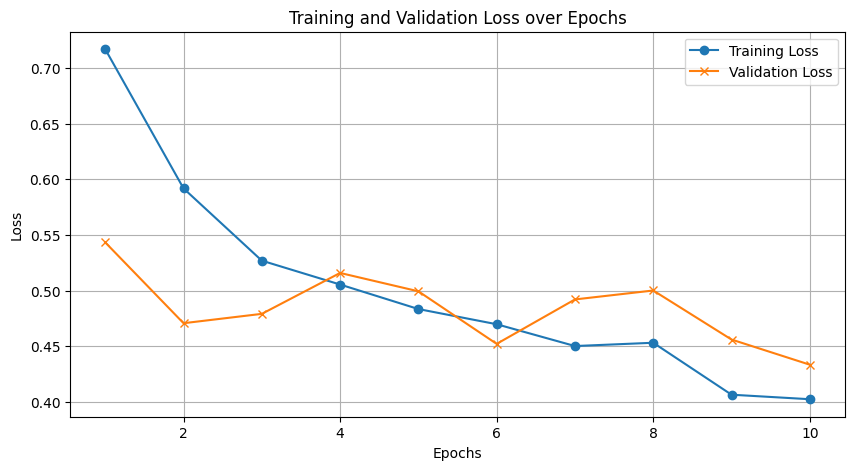

In [24]:
plot_losses(train_losses, val_losses)

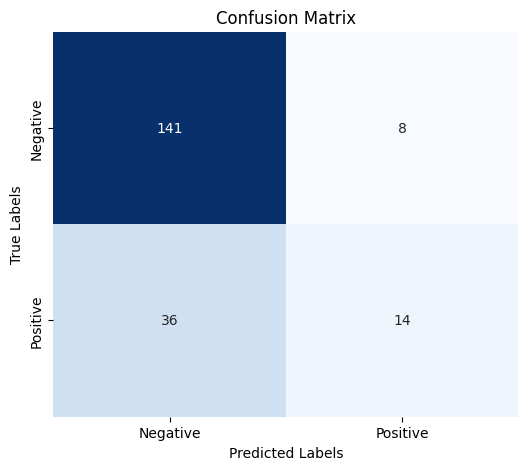

In [25]:
plot_confusion_matrix(test_conf_matrix)

In [26]:
# Display the table
metrics_df

,Train Accuracy,Validation Accuracy,Test Accuracy,Train Precision,Validation Precision,Test Precision,Train Recall,Validation Recall,Test Recall,Train F1 Score,Validation F1 Score,Test F1 Score,Train Loss,Validation Loss,Test Loss
0,0.81014,0.824121,0.778894,0.679012,0.826087,0.636364,0.470085,0.38,0.28,0.555556,0.520548,0.388889,0.402324,0.433349,0.545837


In [27]:
# Print sizes of each DataLoader (FOR CHECKING)
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")


Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### Cross-Validation

In [28]:
def plot_average_loss_curves(train_losses_folds, val_losses_folds):
    # Transpose folds to calculate averages and standard deviations per epoch
    num_epochs = len(train_losses_folds[0])
    
    # Calculate average and standard deviation for training losses
    avg_train_losses = [np.mean([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    std_train_losses = [np.std([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    
    # Calculate average and standard deviation for validation losses
    avg_val_losses = [np.mean([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]
    std_val_losses = [np.std([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]
    
    # Define the epochs
    epochs = range(1, num_epochs + 1)
    
    # Plotting
    plt.figure(figsize=(12, 7))
    
    # Plot average training loss with markers and shaded standard deviation
    plt.plot(epochs, avg_train_losses, label='Average Training Loss', color='#1f77b4', linewidth=2, marker='o')
    plt.fill_between(epochs, 
                     np.array(avg_train_losses) - np.array(std_train_losses), 
                     np.array(avg_train_losses) + np.array(std_train_losses), 
                     color='#1f77b4', alpha=0.2)
    
    # Plot average validation loss with markers and shaded standard deviation
    plt.plot(epochs, avg_val_losses, label='Average Validation Loss', color='#ff7f0e', linewidth=2, marker='o')
    plt.fill_between(epochs, 
                     np.array(avg_val_losses) - np.array(std_val_losses), 
                     np.array(avg_val_losses) + np.array(std_val_losses), 
                     color='#ff7f0e', alpha=0.2)
    
    # Add titles and labels
    plt.title('Average Training and Validation Loss Across Folds', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Highlight the minimum validation loss epoch
    min_val_epoch = np.argmin(avg_val_losses) + 1
    min_val_loss = avg_val_losses[min_val_epoch - 1]
    plt.scatter(min_val_epoch, min_val_loss, color='red', zorder=5)
    
    # Dynamically position the annotation text slightly above the marker
    text_offset = (max(avg_val_losses) - min(avg_val_losses)) * 0.05
    plt.text(min_val_epoch, min_val_loss + text_offset, 
             f'Min Val Loss: {min_val_loss:.4f}', 
             color='black', fontsize=12, ha='center')
    
    # Add legend
    plt.legend(fontsize=12, frameon=True, edgecolor='black')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [29]:
def visualize_kfold_distribution(fold_data, num_folds):

    training_color = "#3399ff"
    testing_color = "#ff9933"  

    plt.figure(figsize=(14, 7))
    
    for fold_idx, fold in enumerate(fold_data):
        for sample_idx, val in enumerate(fold):
            if val == 1:  
                plt.barh(fold_idx, width=1, left=sample_idx, color=training_color)
            elif val == -1:  
                plt.barh(fold_idx, width=1, left=sample_idx, color=testing_color)

    # Enhance plot aesthetics
    plt.title("K-Fold Training and Testing Set Distribution", fontsize=18, weight='bold', pad=20)
    plt.xlabel("Data Index", fontsize=14, labelpad=10)
    plt.ylabel("Fold", fontsize=14, labelpad=10)
    plt.yticks(range(num_folds), [f"Fold {i+1}" for i in range(num_folds)], fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Create a custom legend
    training_patch = mpatches.Patch(color=training_color, label='Training Set')
    testing_patch = mpatches.Patch(color=testing_color, label='Testing Set')
    plt.legend(handles=[training_patch, testing_patch], loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')
    
    plt.tight_layout()
    plt.show()

In [30]:
def print_cv_dataloader(dataloader, name="Dataloader"):
    total_samples = len(dataloader.sampler)
    num_batches = len(dataloader)
    print(f"{name}: Total Samples = {total_samples}, Number of Batches = {num_batches}")

In [31]:
def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs, 
    output_dim,
    criterion,
    learning_rate,
    train_batch_size,
    val_batch_size,
    output_file,
    device=None
):
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    set_seed(42)  # Set global seed at the start
    
    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    
    # Lists to store metrics and losses for each fold
    train_losses_folds = []  # List of lists: train_losses_folds[fold][epoch]
    val_losses_folds = []    # List of lists: val_losses_folds[fold][epoch]
    
    print("Number of Epochs:", num_epochs)
    print("learning rate:", learning_rate)
    
    # Visualization data structure
    num_samples = len(dataset)
    fold_data = np.zeros((num_folds, num_samples))  # Rows: folds, Columns: dataset samples
    
    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")
        
        # Mark train and test samples for visualization
        fold_data[fold, train_idx] = 1  # Training set
        fold_data[fold, val_idx] = -1  # Testing set
        
        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        print_cv_dataloader(train_dataloader, "Train DataLoader")
        print_cv_dataloader(val_dataloader, "Validation DataLoader")
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(device).to(device)
        
        dense_layer = dense_layer_class(output_dim * max_pad).to(device)
        criterion = criterion.to(device)
        optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

        scheduler = ExponentialLR(optimizer, gamma=decay_rate)
        
        # Initialize lists to track losses for this fold
        train_losses = []
        val_losses = []
        
        # Use tqdm for progress bar
        epoch_progress = tqdm(range(num_epochs), desc=f"Fold {fold + 1}/{num_folds} Training", leave=True)


        # Training loop for each fold
        for epoch in epoch_progress:
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            # Track losses for this fold and epoch
            train_losses.append(train_average_loss)
            val_losses.append(val_average_loss)
            
            print(f"\nTrain Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision: {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 Score: {train_f1_score:.4f}")
            print(f"Train Loss: {train_average_loss:.4f}")
            
            print(f"\nEval Accuracy: {val_accuracy:.4f}")
            print(f"Eval Precision: {val_precision:.4f}")   
            print(f"Eval Recall: {val_recall:.4f}")
            print(f"Eval F1 Score: {val_f1_score:.4f}")
            print(f"Eval Loss: {val_average_loss:.4f}")

            # Update learning rate
            scheduler.step()

            # Log current learning rate
            current_lr = scheduler.get_last_lr()[0]
            print(f"Learning Rate after Epoch {epoch + 1}: {current_lr:.8f}")
            
            # Update tqdm progress bar description
            epoch_progress.set_postfix({
                "Train Loss": f"{train_average_loss:.4f}",
                "Val Loss": f"{val_average_loss:.4f}",
                "Train F1": f"{train_f1_score:.4f}",
                "Val F1": f"{val_f1_score:.4f}",
            })
        
        # Store losses for the fold
        train_losses_folds.append(train_losses)
        val_losses_folds.append(val_losses)
           
        # Store the validation metrics for this fold
        fold_losses.append(val_average_loss)
        fold_accuracies.append(val_accuracy)
        fold_precisions.append(val_precision)
        fold_recalls.append(val_recall)
        fold_f1_scores.append(val_f1_score)

    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    results_dict = {"Metrics": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"]}
    for i in range(num_folds):
        results_dict[f"Fold {i + 1}"] = [fold_losses[i], fold_accuracies[i], fold_precisions[i], fold_recalls[i], fold_f1_scores[i]]
    results_dict["Average"] = [avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score]

    # Create DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  
        
    # Save results to .csv
    results_df.to_csv(output_file, index=False)
    
    return results_df, train_losses_folds, val_losses_folds, fold_data

In [32]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer
    
output_dim = 768

# Run k-fold cross-validation   
results_df, train_losses_folds, val_losses_folds, fold_data = cross_validate_model(
    dataset=full_dataset,
    model_class=SimultaneousParallel,
    dense_layer_class=dense_layer_class,
    criterion=criterion,
    output_dim=output_dim,
    num_epochs=num_epochs_cv,    
    num_folds=num_folds,
    train_batch_size=train_batch_size,
    val_batch_size=val_batch_size,
    learning_rate=learning_rate,
    output_file=f'results/simulParallel/SimulParallel-CV_scores.csv'
)

Device: cuda
Number of Epochs: 10
learning rate: 0.0001
------------------------------------------------------------
------------------------- Fold 1/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 1/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 1/5 Training:  10%|█         | 1/10 [03:09<28:22, 189.21s/it, Train Loss=0.7302, Val Loss=0.5700, Train F1=0.2850, Val F1=0.3967]


Train Accuracy: 0.7160
Train Precision: 0.3846
Train Recall: 0.2264
Train F1 Score: 0.2850
Train Loss: 0.7302

Eval Accuracy: 0.7245
Eval Precision: 0.4615
Eval Recall: 0.3478
Eval F1 Score: 0.3967
Eval Loss: 0.5700
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 1/5 Training:  20%|██        | 2/10 [06:25<25:48, 193.56s/it, Train Loss=0.5670, Val Loss=0.5532, Train F1=0.4101, Val F1=0.1750]


Train Accuracy: 0.7368
Train Precision: 0.4663
Train Recall: 0.3660
Train F1 Score: 0.4101
Train Loss: 0.5670

Eval Accuracy: 0.7509
Eval Precision: 0.6364
Eval Recall: 0.1014
Eval F1 Score: 0.1750
Eval Loss: 0.5532
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 1/5 Training:  30%|███       | 3/10 [09:41<22:41, 194.47s/it, Train Loss=0.5226, Val Loss=0.5811, Train F1=0.4151, Val F1=0.2804]


Train Accuracy: 0.7660
Train Precision: 0.5535
Train Recall: 0.3321
Train F1 Score: 0.4151
Train Loss: 0.5226

Eval Accuracy: 0.7094
Eval Precision: 0.3947
Eval Recall: 0.2174
Eval F1 Score: 0.2804
Eval Loss: 0.5811
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 1/5 Training:  40%|████      | 4/10 [12:56<19:29, 194.89s/it, Train Loss=0.4624, Val Loss=0.5190, Train F1=0.4962, Val F1=0.4158]


Train Accuracy: 0.8104
Train Precision: 0.7388
Train Recall: 0.3736
Train F1 Score: 0.4962
Train Loss: 0.4624

Eval Accuracy: 0.7774
Eval Precision: 0.6562
Eval Recall: 0.3043
Eval F1 Score: 0.4158
Eval Loss: 0.5190
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 1/5 Training:  50%|█████     | 5/10 [16:11<16:14, 194.96s/it, Train Loss=0.4696, Val Loss=0.4939, Train F1=0.4965, Val F1=0.4865]


Train Accuracy: 0.7991
Train Precision: 0.6646
Train Recall: 0.3962
Train F1 Score: 0.4965
Train Loss: 0.4696

Eval Accuracy: 0.7849
Eval Precision: 0.6429
Eval Recall: 0.3913
Eval F1 Score: 0.4865
Eval Loss: 0.4939
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 1/5 Training:  60%|██████    | 6/10 [19:27<13:00, 195.03s/it, Train Loss=0.4508, Val Loss=0.5016, Train F1=0.4927, Val F1=0.4737]


Train Accuracy: 0.8038
Train Precision: 0.6966
Train Recall: 0.3811
Train F1 Score: 0.4927
Train Loss: 0.4508

Eval Accuracy: 0.7736
Eval Precision: 0.6000
Eval Recall: 0.3913
Eval F1 Score: 0.4737
Eval Loss: 0.5016
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 1/5 Training:  70%|███████   | 7/10 [22:43<09:45, 195.32s/it, Train Loss=0.4567, Val Loss=0.5687, Train F1=0.4416, Val F1=0.3429]


Train Accuracy: 0.7925
Train Precision: 0.6744
Train Recall: 0.3283
Train F1 Score: 0.4416
Train Loss: 0.4567

Eval Accuracy: 0.7396
Eval Precision: 0.5000
Eval Recall: 0.2609
Eval F1 Score: 0.3429
Eval Loss: 0.5687
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 1/5 Training:  80%|████████  | 8/10 [25:58<06:30, 195.32s/it, Train Loss=0.4026, Val Loss=0.5275, Train F1=0.5642, Val F1=0.3960]


Train Accuracy: 0.8208
Train Precision: 0.7193
Train Recall: 0.4642
Train F1 Score: 0.5642
Train Loss: 0.4026

Eval Accuracy: 0.7698
Eval Precision: 0.6250
Eval Recall: 0.2899
Eval F1 Score: 0.3960
Eval Loss: 0.5275
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 1/5 Training:  90%|█████████ | 9/10 [29:13<03:15, 195.25s/it, Train Loss=0.4157, Val Loss=0.5569, Train F1=0.5111, Val F1=0.3800]


Train Accuracy: 0.8123
Train Precision: 0.7324
Train Recall: 0.3925
Train F1 Score: 0.5111
Train Loss: 0.4157

Eval Accuracy: 0.7660
Eval Precision: 0.6129
Eval Recall: 0.2754
Eval F1 Score: 0.3800
Eval Loss: 0.5569
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 1/5 Training: 100%|██████████| 10/10 [32:28<00:00, 194.89s/it, Train Loss=0.3826, Val Loss=0.5149, Train F1=0.5545, Val F1=0.4035]


Train Accuracy: 0.8226
Train Precision: 0.7452
Train Recall: 0.4415
Train F1 Score: 0.5545
Train Loss: 0.3826

Eval Accuracy: 0.7434
Eval Precision: 0.5111
Eval Recall: 0.3333
Eval F1 Score: 0.4035
Eval Loss: 0.5149
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 2/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 2/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 2/5 Training:  10%|█         | 1/10 [03:01<27:17, 181.90s/it, Train Loss=0.7788, Val Loss=0.5207, Train F1=0.2664, Val F1=0.4182]


Train Accuracy: 0.6830
Train Precision: 0.3245
Train Recall: 0.2259
Train F1 Score: 0.2664
Train Loss: 0.7788

Eval Accuracy: 0.7585
Eval Precision: 0.5000
Eval Recall: 0.3594
Eval F1 Score: 0.4182
Eval Loss: 0.5207
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 2/5 Training:  20%|██        | 2/10 [06:06<24:26, 183.26s/it, Train Loss=0.5360, Val Loss=0.6175, Train F1=0.4525, Val F1=0.2368]


Train Accuracy: 0.7717
Train Precision: 0.5814
Train Recall: 0.3704
Train F1 Score: 0.4525
Train Loss: 0.5360

Eval Accuracy: 0.7811
Eval Precision: 0.7500
Eval Recall: 0.1406
Eval F1 Score: 0.2368
Eval Loss: 0.6175
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 2/5 Training:  30%|███       | 3/10 [09:09<21:23, 183.35s/it, Train Loss=0.4993, Val Loss=0.6423, Train F1=0.4802, Val F1=0.2469]


Train Accuracy: 0.7774
Train Precision: 0.5924
Train Recall: 0.4037
Train F1 Score: 0.4802
Train Loss: 0.4993

Eval Accuracy: 0.7698
Eval Precision: 0.5882
Eval Recall: 0.1562
Eval F1 Score: 0.2469
Eval Loss: 0.6423
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 2/5 Training:  40%|████      | 4/10 [12:12<18:19, 183.31s/it, Train Loss=0.4817, Val Loss=0.5090, Train F1=0.5208, Val F1=0.2970]


Train Accuracy: 0.7934
Train Precision: 0.6364
Train Recall: 0.4407
Train F1 Score: 0.5208
Train Loss: 0.4817

Eval Accuracy: 0.7321
Eval Precision: 0.4054
Eval Recall: 0.2344
Eval F1 Score: 0.2970
Eval Loss: 0.5090
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 2/5 Training:  50%|█████     | 5/10 [15:15<15:16, 183.24s/it, Train Loss=0.4971, Val Loss=0.5503, Train F1=0.5249, Val F1=0.1951]


Train Accuracy: 0.8019
Train Precision: 0.6744
Train Recall: 0.4296
Train F1 Score: 0.5249
Train Loss: 0.4971

Eval Accuracy: 0.7509
Eval Precision: 0.4444
Eval Recall: 0.1250
Eval F1 Score: 0.1951
Eval Loss: 0.5503
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 2/5 Training:  60%|██████    | 6/10 [18:19<12:13, 183.42s/it, Train Loss=0.4610, Val Loss=0.4610, Train F1=0.4792, Val F1=0.4583]


Train Accuracy: 0.7991
Train Precision: 0.7050
Train Recall: 0.3630
Train F1 Score: 0.4792
Train Loss: 0.4610

Eval Accuracy: 0.8038
Eval Precision: 0.6875
Eval Recall: 0.3438
Eval F1 Score: 0.4583
Eval Loss: 0.4610
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 2/5 Training:  70%|███████   | 7/10 [21:23<09:10, 183.43s/it, Train Loss=0.4612, Val Loss=0.4520, Train F1=0.4772, Val F1=0.3171]


Train Accuracy: 0.7726
Train Precision: 0.5759
Train Recall: 0.4074
Train F1 Score: 0.4772
Train Loss: 0.4612

Eval Accuracy: 0.7887
Eval Precision: 0.7222
Eval Recall: 0.2031
Eval F1 Score: 0.3171
Eval Loss: 0.4520
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 2/5 Training:  80%|████████  | 8/10 [24:26<06:06, 183.36s/it, Train Loss=0.4085, Val Loss=0.5105, Train F1=0.5714, Val F1=0.4130]


Train Accuracy: 0.8217
Train Precision: 0.7368
Train Recall: 0.4667
Train F1 Score: 0.5714
Train Loss: 0.4085

Eval Accuracy: 0.7962
Eval Precision: 0.6786
Eval Recall: 0.2969
Eval F1 Score: 0.4130
Eval Loss: 0.5105
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 2/5 Training:  90%|█████████ | 9/10 [27:29<03:03, 183.24s/it, Train Loss=0.4191, Val Loss=0.4732, Train F1=0.5337, Val F1=0.3956]


Train Accuracy: 0.8170
Train Precision: 0.7603
Train Recall: 0.4111
Train F1 Score: 0.5337
Train Loss: 0.4191

Eval Accuracy: 0.7925
Eval Precision: 0.6667
Eval Recall: 0.2812
Eval F1 Score: 0.3956
Eval Loss: 0.4732
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 2/5 Training: 100%|██████████| 10/10 [30:32<00:00, 183.23s/it, Train Loss=0.4254, Val Loss=0.5030, Train F1=0.5471, Val F1=0.5000]


Train Accuracy: 0.8142
Train Precision: 0.7212
Train Recall: 0.4407
Train F1 Score: 0.5471
Train Loss: 0.4254

Eval Accuracy: 0.8038
Eval Precision: 0.6500
Eval Recall: 0.4062
Eval F1 Score: 0.5000
Eval Loss: 0.5030
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 3/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 3/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 3/5 Training:  10%|█         | 1/10 [03:04<27:43, 184.87s/it, Train Loss=0.6507, Val Loss=0.5642, Train F1=0.2918, Val F1=0.3704]


Train Accuracy: 0.7160
Train Precision: 0.3713
Train Recall: 0.2403
Train F1 Score: 0.2918
Train Loss: 0.6507

Eval Accuracy: 0.6792
Eval Precision: 0.4237
Eval Recall: 0.3289
Eval F1 Score: 0.3704
Eval Loss: 0.5642
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 3/5 Training:  20%|██        | 2/10 [06:19<25:24, 190.62s/it, Train Loss=0.6069, Val Loss=0.6397, Train F1=0.3990, Val F1=0.1205]


Train Accuracy: 0.7613
Train Precision: 0.5153
Train Recall: 0.3256
Train F1 Score: 0.3990
Train Loss: 0.6069

Eval Accuracy: 0.7245
Eval Precision: 0.7143
Eval Recall: 0.0658
Eval F1 Score: 0.1205
Eval Loss: 0.6397
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 3/5 Training:  30%|███       | 3/10 [09:34<22:29, 192.77s/it, Train Loss=0.5121, Val Loss=0.5197, Train F1=0.3860, Val F1=0.5197]


Train Accuracy: 0.7689
Train Precision: 0.5461
Train Recall: 0.2984
Train F1 Score: 0.3860
Train Loss: 0.5121

Eval Accuracy: 0.7698
Eval Precision: 0.6471
Eval Recall: 0.4342
Eval F1 Score: 0.5197
Eval Loss: 0.5197
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 3/5 Training:  40%|████      | 4/10 [12:49<19:21, 193.57s/it, Train Loss=0.5048, Val Loss=0.4866, Train F1=0.4000, Val F1=0.5714]


Train Accuracy: 0.7736
Train Precision: 0.5634
Train Recall: 0.3101
Train F1 Score: 0.4000
Train Loss: 0.5048

Eval Accuracy: 0.7736
Eval Precision: 0.6250
Eval Recall: 0.5263
Eval F1 Score: 0.5714
Eval Loss: 0.4866
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 3/5 Training:  50%|█████     | 5/10 [16:04<16:09, 193.99s/it, Train Loss=0.4585, Val Loss=0.4878, Train F1=0.5170, Val F1=0.4381]


Train Accuracy: 0.7991
Train Precision: 0.6230
Train Recall: 0.4419
Train F1 Score: 0.5170
Train Loss: 0.4585

Eval Accuracy: 0.7774
Eval Precision: 0.7931
Eval Recall: 0.3026
Eval F1 Score: 0.4381
Eval Loss: 0.4878
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 3/5 Training:  60%|██████    | 6/10 [19:19<12:57, 194.40s/it, Train Loss=0.4543, Val Loss=0.5168, Train F1=0.4976, Val F1=0.4685]


Train Accuracy: 0.8019
Train Precision: 0.6500
Train Recall: 0.4031
Train F1 Score: 0.4976
Train Loss: 0.4543

Eval Accuracy: 0.7774
Eval Precision: 0.7429
Eval Recall: 0.3421
Eval F1 Score: 0.4685
Eval Loss: 0.5168
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 3/5 Training:  70%|███████   | 7/10 [22:34<09:44, 194.71s/it, Train Loss=0.4568, Val Loss=0.4662, Train F1=0.4503, Val F1=0.5614]


Train Accuracy: 0.8019
Train Precision: 0.6935
Train Recall: 0.3333
Train F1 Score: 0.4503
Train Loss: 0.4568

Eval Accuracy: 0.8113
Eval Precision: 0.8421
Eval Recall: 0.4211
Eval F1 Score: 0.5614
Eval Loss: 0.4662
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 3/5 Training:  80%|████████  | 8/10 [25:50<06:29, 194.90s/it, Train Loss=0.4474, Val Loss=0.5073, Train F1=0.4422, Val F1=0.4112]


Train Accuracy: 0.7953
Train Precision: 0.6565
Train Recall: 0.3333
Train F1 Score: 0.4422
Train Loss: 0.4474

Eval Accuracy: 0.7623
Eval Precision: 0.7097
Eval Recall: 0.2895
Eval F1 Score: 0.4112
Eval Loss: 0.5073
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 3/5 Training:  90%|█████████ | 9/10 [29:06<03:15, 195.19s/it, Train Loss=0.4074, Val Loss=0.4580, Train F1=0.5330, Val F1=0.5505]


Train Accuracy: 0.8264
Train Precision: 0.7721
Train Recall: 0.4070
Train F1 Score: 0.5330
Train Loss: 0.4074

Eval Accuracy: 0.8151
Eval Precision: 0.9091
Eval Recall: 0.3947
Eval F1 Score: 0.5505
Eval Loss: 0.4580
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 3/5 Training: 100%|██████████| 10/10 [32:20<00:00, 194.07s/it, Train Loss=0.4072, Val Loss=0.4654, Train F1=0.5463, Val F1=0.5273]


Train Accuracy: 0.8245
Train Precision: 0.7368
Train Recall: 0.4341
Train F1 Score: 0.5463
Train Loss: 0.4072

Eval Accuracy: 0.8038
Eval Precision: 0.8529
Eval Recall: 0.3816
Eval F1 Score: 0.5273
Eval Loss: 0.4654
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 4/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 4/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 4/5 Training:  10%|█         | 1/10 [03:03<27:30, 183.35s/it, Train Loss=0.7002, Val Loss=0.5054, Train F1=0.3009, Val F1=0.3226]


Train Accuracy: 0.7019
Train Precision: 0.3778
Train Recall: 0.2500
Train F1 Score: 0.3009
Train Loss: 0.7002

Eval Accuracy: 0.7623
Eval Precision: 0.4839
Eval Recall: 0.2419
Eval F1 Score: 0.3226
Eval Loss: 0.5054
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 4/5 Training:  20%|██        | 2/10 [06:07<24:31, 183.90s/it, Train Loss=0.5502, Val Loss=0.5511, Train F1=0.4170, Val F1=0.3265]


Train Accuracy: 0.7547
Train Precision: 0.5345
Train Recall: 0.3419
Train F1 Score: 0.4170
Train Loss: 0.5502

Eval Accuracy: 0.7509
Eval Precision: 0.4444
Eval Recall: 0.2581
Eval F1 Score: 0.3265
Eval Loss: 0.5511
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 4/5 Training:  30%|███       | 3/10 [09:11<21:26, 183.80s/it, Train Loss=0.5630, Val Loss=0.4512, Train F1=0.4489, Val F1=0.5614]


Train Accuracy: 0.7660
Train Precision: 0.5674
Train Recall: 0.3713
Train F1 Score: 0.4489
Train Loss: 0.5630

Eval Accuracy: 0.8113
Eval Precision: 0.6154
Eval Recall: 0.5161
Eval F1 Score: 0.5614
Eval Loss: 0.4512
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 4/5 Training:  40%|████      | 4/10 [12:15<18:22, 183.77s/it, Train Loss=0.5061, Val Loss=0.5421, Train F1=0.4143, Val F1=0.5290]


Train Accuracy: 0.7679
Train Precision: 0.5878
Train Recall: 0.3199
Train F1 Score: 0.4143
Train Loss: 0.5061

Eval Accuracy: 0.7245
Eval Precision: 0.4409
Eval Recall: 0.6613
Eval F1 Score: 0.5290
Eval Loss: 0.5421
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 4/5 Training:  50%|█████     | 5/10 [15:18<15:17, 183.52s/it, Train Loss=0.4777, Val Loss=0.4605, Train F1=0.4798, Val F1=0.4946]


Train Accuracy: 0.7689
Train Precision: 0.5678
Train Recall: 0.4154
Train F1 Score: 0.4798
Train Loss: 0.4777

Eval Accuracy: 0.8226
Eval Precision: 0.7419
Eval Recall: 0.3710
Eval F1 Score: 0.4946
Eval Loss: 0.4605
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 4/5 Training:  60%|██████    | 6/10 [18:21<12:13, 183.37s/it, Train Loss=0.4830, Val Loss=0.4977, Train F1=0.4742, Val F1=0.4167]


Train Accuracy: 0.7887
Train Precision: 0.6558
Train Recall: 0.3713
Train F1 Score: 0.4742
Train Loss: 0.4830

Eval Accuracy: 0.7887
Eval Precision: 0.5882
Eval Recall: 0.3226
Eval F1 Score: 0.4167
Eval Loss: 0.4977
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 4/5 Training:  70%|███████   | 7/10 [21:25<09:10, 183.56s/it, Train Loss=0.4666, Val Loss=0.5120, Train F1=0.5113, Val F1=0.4286]


Train Accuracy: 0.7962
Train Precision: 0.6647
Train Recall: 0.4154
Train F1 Score: 0.5113
Train Loss: 0.4666

Eval Accuracy: 0.7887
Eval Precision: 0.5833
Eval Recall: 0.3387
Eval F1 Score: 0.4286
Eval Loss: 0.5120
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 4/5 Training:  80%|████████  | 8/10 [24:28<06:06, 183.35s/it, Train Loss=0.4252, Val Loss=0.4691, Train F1=0.5294, Val F1=0.4950]


Train Accuracy: 0.8038
Train Precision: 0.6882
Train Recall: 0.4301
Train F1 Score: 0.5294
Train Loss: 0.4252

Eval Accuracy: 0.8075
Eval Precision: 0.6410
Eval Recall: 0.4032
Eval F1 Score: 0.4950
Eval Loss: 0.4691
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 4/5 Training:  90%|█████████ | 9/10 [27:31<03:03, 183.33s/it, Train Loss=0.4159, Val Loss=0.5050, Train F1=0.5776, Val F1=0.4242]


Train Accuracy: 0.8151
Train Precision: 0.6979
Train Recall: 0.4926
Train F1 Score: 0.5776
Train Loss: 0.4159

Eval Accuracy: 0.7849
Eval Precision: 0.5676
Eval Recall: 0.3387
Eval F1 Score: 0.4242
Eval Loss: 0.5050
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 4/5 Training: 100%|██████████| 10/10 [30:34<00:00, 183.46s/it, Train Loss=0.4460, Val Loss=0.4722, Train F1=0.4952, Val F1=0.4270]


Train Accuracy: 0.8000
Train Precision: 0.7027
Train Recall: 0.3824
Train F1 Score: 0.4952
Train Loss: 0.4460

Eval Accuracy: 0.8075
Eval Precision: 0.7037
Eval Recall: 0.3065
Eval F1 Score: 0.4270
Eval Loss: 0.4722
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 5/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17



Fold 5/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 5/5 Training:  10%|█         | 1/10 [03:04<27:43, 184.84s/it, Train Loss=0.6885, Val Loss=0.5724, Train F1=0.2691, Val F1=0.2326]


Train Accuracy: 0.6925
Train Precision: 0.3429
Train Recall: 0.2214
Train F1 Score: 0.2691
Train Loss: 0.6885

Eval Accuracy: 0.7509
Eval Precision: 0.4348
Eval Recall: 0.1587
Eval F1 Score: 0.2326
Eval Loss: 0.5724
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 5/5 Training:  20%|██        | 2/10 [06:09<24:36, 184.51s/it, Train Loss=0.6040, Val Loss=0.4616, Train F1=0.3514, Val F1=0.3415]


Train Accuracy: 0.7179
Train Precision: 0.4263
Train Recall: 0.2989
Train F1 Score: 0.3514
Train Loss: 0.6040

Eval Accuracy: 0.7962
Eval Precision: 0.7368
Eval Recall: 0.2222
Eval F1 Score: 0.3415
Eval Loss: 0.4616
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 5/5 Training:  30%|███       | 3/10 [09:23<22:04, 189.17s/it, Train Loss=0.5190, Val Loss=0.5109, Train F1=0.4095, Val F1=0.3958]


Train Accuracy: 0.7415
Train Precision: 0.4922
Train Recall: 0.3506
Train F1 Score: 0.4095
Train Loss: 0.5190

Eval Accuracy: 0.7811
Eval Precision: 0.5758
Eval Recall: 0.3016
Eval F1 Score: 0.3958
Eval Loss: 0.5109
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 5/5 Training:  40%|████      | 4/10 [12:39<19:09, 191.59s/it, Train Loss=0.5107, Val Loss=0.5204, Train F1=0.4424, Val F1=0.1687]


Train Accuracy: 0.7670
Train Precision: 0.5698
Train Recall: 0.3616
Train F1 Score: 0.4424
Train Loss: 0.5107

Eval Accuracy: 0.7396
Eval Precision: 0.3500
Eval Recall: 0.1111
Eval F1 Score: 0.1687
Eval Loss: 0.5204
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 5/5 Training:  50%|█████     | 5/10 [15:55<16:07, 193.47s/it, Train Loss=0.5030, Val Loss=0.4343, Train F1=0.4037, Val F1=0.3830]


Train Accuracy: 0.7547
Train Precision: 0.5333
Train Recall: 0.3247
Train F1 Score: 0.4037
Train Loss: 0.5030

Eval Accuracy: 0.7811
Eval Precision: 0.5806
Eval Recall: 0.2857
Eval F1 Score: 0.3830
Eval Loss: 0.4343
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 5/5 Training:  60%|██████    | 6/10 [19:11<12:56, 194.09s/it, Train Loss=0.4809, Val Loss=0.4745, Train F1=0.4920, Val F1=0.5120]


Train Accuracy: 0.7896
Train Precision: 0.6429
Train Recall: 0.3985
Train F1 Score: 0.4920
Train Loss: 0.4809

Eval Accuracy: 0.7698
Eval Precision: 0.5161
Eval Recall: 0.5079
Eval F1 Score: 0.5120
Eval Loss: 0.4745
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 5/5 Training:  70%|███████   | 7/10 [22:27<09:44, 194.71s/it, Train Loss=0.4383, Val Loss=0.4273, Train F1=0.5315, Val F1=0.5053]


Train Accuracy: 0.8038
Train Precision: 0.6821
Train Recall: 0.4354
Train F1 Score: 0.5315
Train Loss: 0.4383

Eval Accuracy: 0.8226
Eval Precision: 0.7500
Eval Recall: 0.3810
Eval F1 Score: 0.5053
Eval Loss: 0.4273
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 5/5 Training:  80%|████████  | 8/10 [25:42<06:29, 194.90s/it, Train Loss=0.4303, Val Loss=0.5084, Train F1=0.5238, Val F1=0.4394]


Train Accuracy: 0.8113
Train Precision: 0.7383
Train Recall: 0.4059
Train F1 Score: 0.5238
Train Loss: 0.4303

Eval Accuracy: 0.7208
Eval Precision: 0.4203
Eval Recall: 0.4603
Eval F1 Score: 0.4394
Eval Loss: 0.5084
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 5/5 Training:  90%|█████████ | 9/10 [28:58<03:15, 195.18s/it, Train Loss=0.3980, Val Loss=0.4114, Train F1=0.6223, Val F1=0.4946]


Train Accuracy: 0.8340
Train Precision: 0.7436
Train Recall: 0.5351
Train F1 Score: 0.6223
Train Loss: 0.3980

Eval Accuracy: 0.8226
Eval Precision: 0.7667
Eval Recall: 0.3651
Eval F1 Score: 0.4946
Eval Loss: 0.4114
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 5/5 Training: 100%|██████████| 10/10 [32:13<00:00, 193.38s/it, Train Loss=0.3881, Val Loss=0.4623, Train F1=0.5768, Val F1=0.4330]


Train Accuracy: 0.8311
Train Precision: 0.8026
Train Recall: 0.4502
Train F1 Score: 0.5768
Train Loss: 0.3881

Eval Accuracy: 0.7925
Eval Precision: 0.6176
Eval Recall: 0.3333
Eval F1 Score: 0.4330
Eval Loss: 0.4623
Learning Rate after Epoch 10: 0.00003487
--------------------------------------------------

K-Fold Cross-Validation Results:
Average Loss: 0.4836
Average Accuracy: 0.7902
Average Precision: 0.6671
Average Recall: 0.3522
Average F1 Score: 0.4581


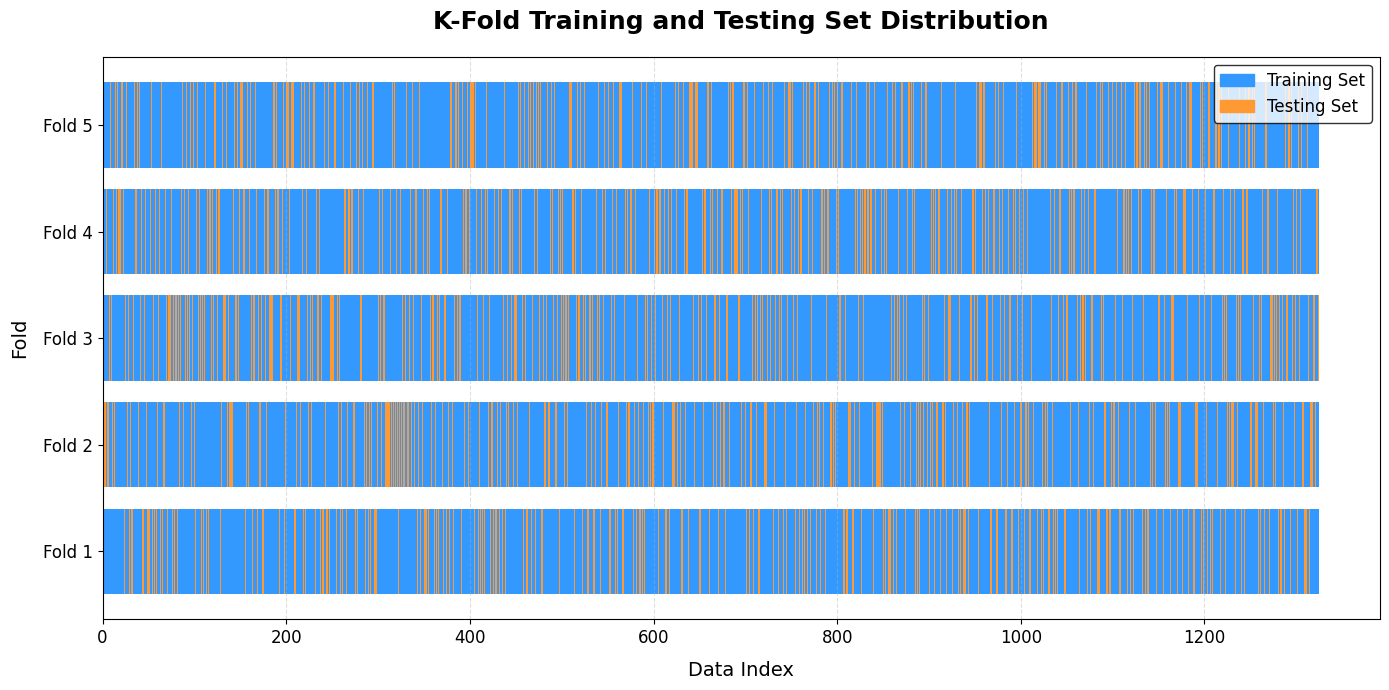

In [33]:
visualize_kfold_distribution(fold_data, num_folds)

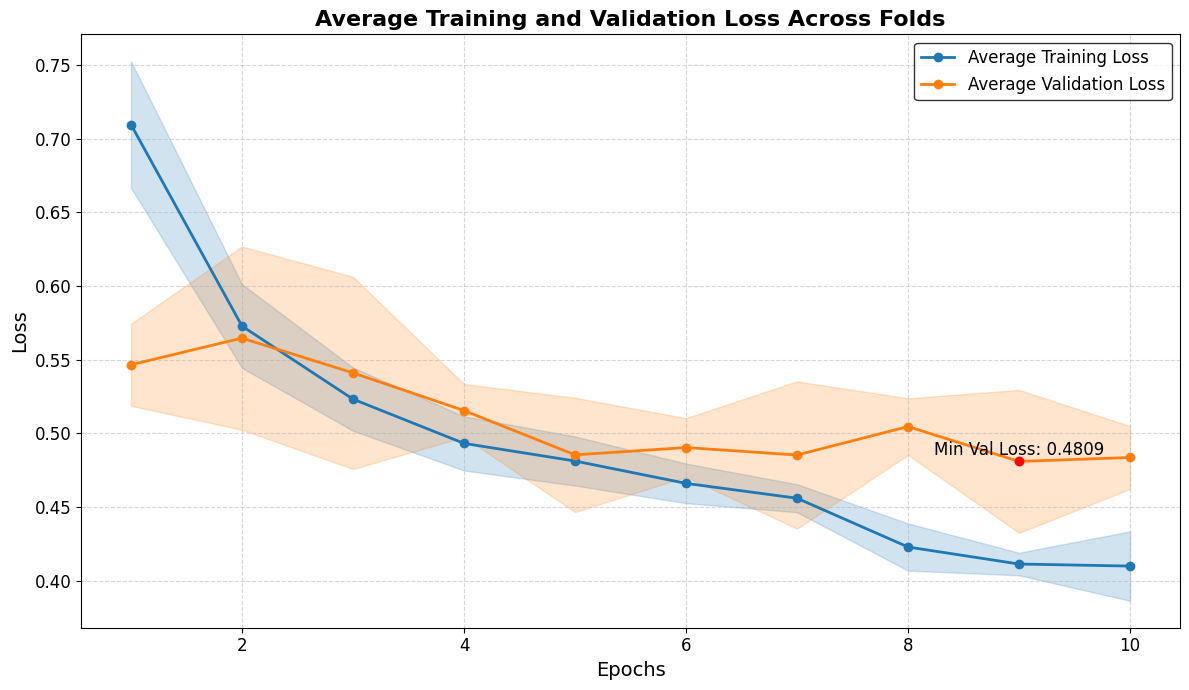

In [34]:
# Plot average loss curves across folds
plot_average_loss_curves(train_losses_folds, val_losses_folds)

In [35]:
df = pd.read_csv(f'results/simulParallel/SimulParallel-CV_scores.csv')
df

,Metrics,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Loss,0.514928,0.503009,0.465449,0.472151,0.462324,0.483572
1,Accuracy,0.743396,0.803774,0.803774,0.807547,0.792453,0.790189
2,Precision,0.511111,0.650000,0.852941,0.703704,0.617647,0.667081
3,Recall,0.333333,0.406250,0.381579,0.306452,0.333333,0.352189
4,F1 Score,0.403509,0.500000,0.527273,0.426966,0.432990,0.458148
